In [25]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import glob
from PIL import Image
import cv2
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

Dataset source:

https://www.kaggle.com/ngbolin/mnist-dataset-digit-recognizer/data?fbclid=IwAR33vMD-lH2mIFOBBIM4bDdjtQ52xmnYLTDTqZQtaKUjHVrnrQP9jrzWXWI

In [2]:
df = pd.read_csv('mnist/digits.csv')
df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
data = df.iloc[:6000, :]
images = data.values.reshape(-1, 28, 28)
print(data.shape)
print(images.shape)

(6000, 784)
(6000, 28, 28)


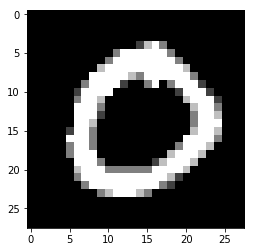

In [4]:
plt.imshow(images[13], cmap='gray')
plt.show()

In [5]:
def imscatter(x, y, images, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()

    im = [OffsetImage(i, zoom=zoom, cmap='gray') for i in images]
    x, y = np.atleast_1d(x, y)
    artists = []
    
    for x0, y0, i in zip(x, y, im):
        ab = AnnotationBbox(i, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
        
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

In [6]:
def plot_random_subset(x, y, images, n, zoom):
    size = len(images)
    
    indices = np.random.choice(np.arange(size), n, replace=False)
    x_sample = x[indices]
    y_sample = y[indices]
    img_sample = images[indices]
    
    return imscatter(x_sample, y_sample, img_sample, zoom=zoom)

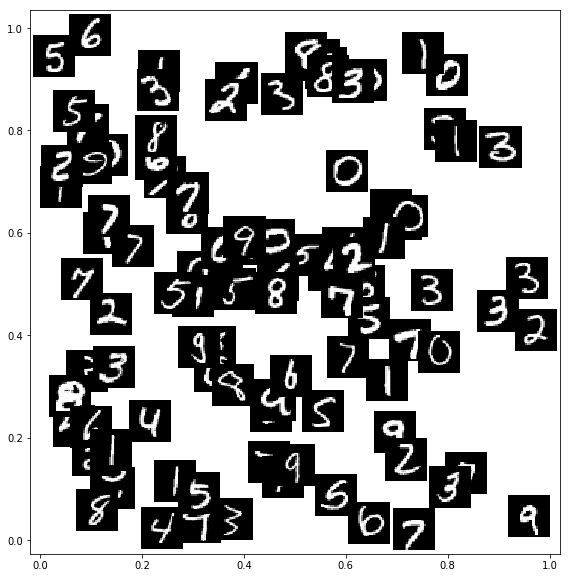

In [7]:
plt.figure(figsize=(9.5, 10))
fig = plot_random_subset(
    np.random.rand(200),
    np.random.rand(200),
    images[:200],
    100,
    zoom=1.5)
plt.show()

In [8]:
def perform_pca(data, number_of_components, scale=False):
    
    if scale:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)

    pca = PCA(n_components=number_of_components)
    components = pca.fit_transform(data)
    components_dataframe = pd.DataFrame(data=components)
    
    return components_dataframe, pca

def perform_kernel_pca(data, number_of_components, scale=False):
    
    if scale:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)

    kpca = KernelPCA(kernel="rbf", n_components=number_of_components)
    components = kpca.fit_transform(data)
    components_dataframe = pd.DataFrame(data=components)
    
    return components_dataframe, kpca

def plot_pca(components, dims, plot_kwargs={}):

    if dims == 2:
        plt.scatter(components[0], components[1], **plot_kwargs)
        plt.xlabel("PC 1")
        plt.ylabel("PC 2")  
        plt.show()
    
    elif dims == 3:
        ax = plt.axes(projection='3d')
        ax.scatter3D(components[0], components[1], components[2], **plot_kwargs);
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')
        ax.set_zlabel('PC 3')
        plt.show()

def display_scree_plot(values, number_of_components=None, percentage=False):
    
    total = sum(values)
    bar_heights = values[:number_of_components]
    
    if percentage:
        bar_heights = list(map(lambda x: x * 100 / total, bar_heights))
        plt.ylabel("[%]")

    bar_x_coordinates = np.array(range(len(bar_heights)))
    labels = ['PC ' + str(i) for i in range(1, len(bar_heights) + 1)]
    
    plt.bar(bar_x_coordinates, bar_heights, tick_label=labels)
    plt.show()
    return

def knn_stats(samples, labels, n_neighbours):
    '''Calculates the percentage of neighbours that belong to the same class for each sample.'''
    
    nbrs = NearestNeighbors(n_neighbours, algorithm='brute').fit(samples)
    distances, indices = nbrs.kneighbors(samples)
    
    neighbour_stats = []
    
    for index, neighbours in enumerate(indices):
        same_cluster_neighbours = filter(
            lambda neighbour: labels[neighbour] == labels[index],
            neighbours
        )
        neighbour_stats.append(len(list(same_cluster_neighbours)) / n_neighbours)
        
    return neighbour_stats

In [9]:
pca_components, pca = perform_pca(data, None, scale=True)
pca_components.head()

/home/jakub/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jakub/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,11.652596,-4.492617,2.899415,-4.150112,0.145202,8.097142,1.504323,0.794648,4.821241,-0.033670,...,0.0,0.0,0.0,0.0,0.0,-0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,18.740757,-0.721959,-5.415140,-3.030355,10.790639,-5.652277,-6.507750,0.263995,0.099080,0.817974,...,0.0,0.0,0.0,0.0,0.0,8.841284e-16,-7.902850e-16,-8.074474e-16,6.199350e-16,-4.324750e-16
2,-5.364112,-0.353672,-0.876264,-1.031426,2.671565,1.628593,0.554787,-2.236293,-1.704060,1.942012,...,0.0,0.0,0.0,0.0,0.0,-5.024350e-17,-1.391319e-15,-1.986396e-16,2.261085e-16,-1.067663e-16
3,-3.221502,-0.664943,-3.670975,-6.189404,0.032728,2.376773,1.114429,0.379116,0.999243,0.592895,...,0.0,0.0,0.0,0.0,0.0,2.454297e-18,5.128265e-18,-3.851570e-18,9.697025e-18,-7.646248e-20
4,-1.737383,-1.651441,7.894133,-0.956657,-2.067010,0.392591,0.133193,1.297631,6.194968,1.626738,...,0.0,0.0,0.0,0.0,0.0,-4.060031e-16,-9.126625e-16,-1.350857e-15,-1.368586e-16,-1.332146e-16


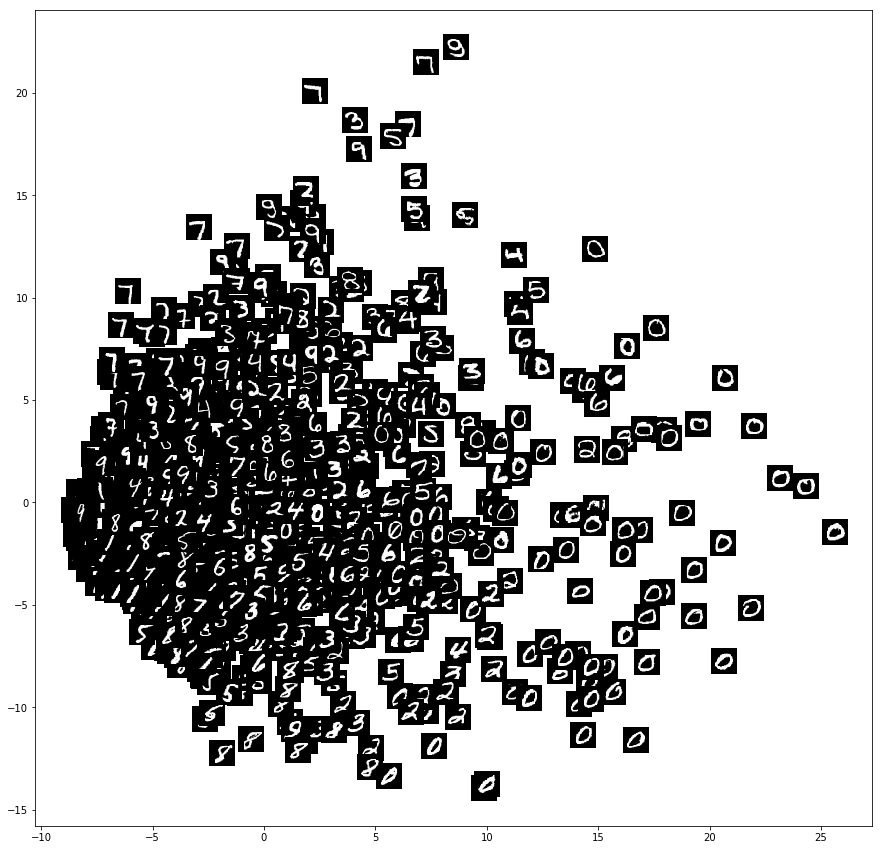

In [10]:
plt.figure(figsize=(15, 15))
fig = plot_random_subset(
    pca_components[0],
    pca_components[1],
    images,
    1000,
    zoom=0.9)

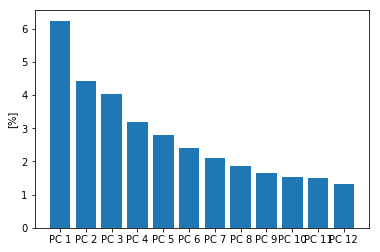

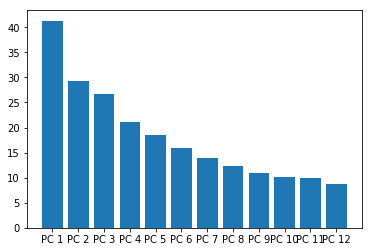

In [11]:
display_scree_plot(pca.explained_variance_, number_of_components=12, percentage=True)
display_scree_plot(pca.explained_variance_, number_of_components=12, percentage=False)

In [12]:
kpca_components, kpca = perform_kernel_pca(data, 7, scale=True)
kpca_components.head()

/home/jakub/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jakub/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,0,1,2,3,4,5,6
0,0.280903,-0.060366,0.055504,-0.085201,-0.068349,-0.061724,0.052459
1,0.387262,-0.056705,-0.033380,-0.037044,-0.071258,0.199632,0.195854
2,-0.162343,-0.003586,-0.093590,-0.084280,0.011859,-0.042333,0.070806
3,-0.169763,0.094727,-0.079983,-0.133404,-0.164625,-0.118592,0.125899
4,-0.100312,-0.151722,0.187879,0.066066,0.036362,-0.164652,-0.043779


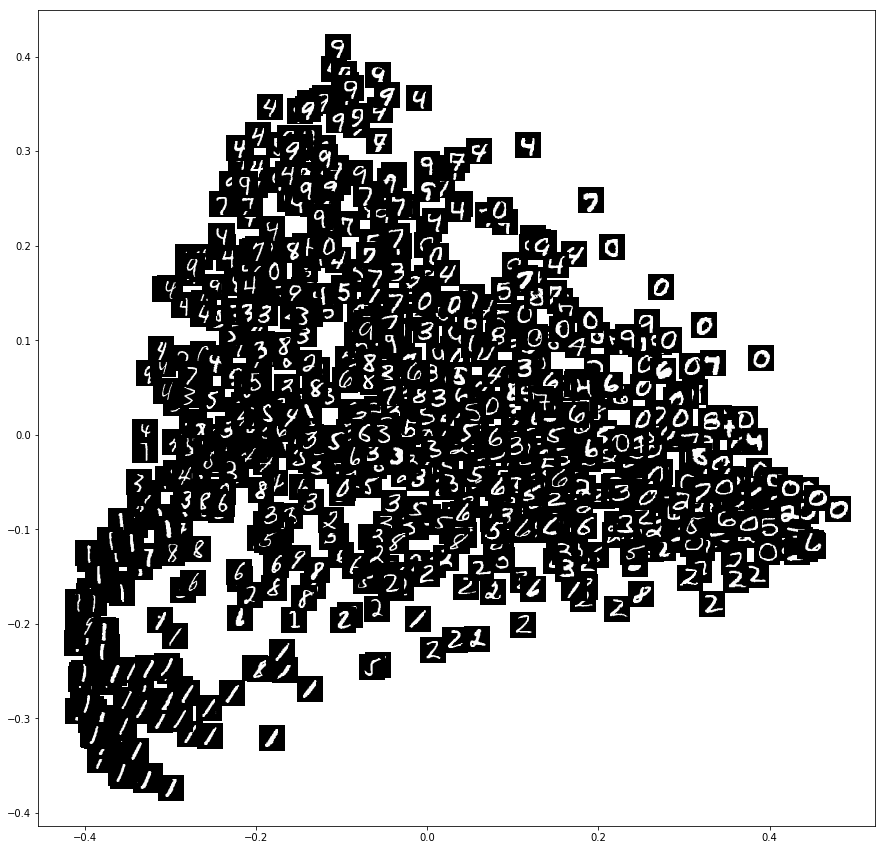

In [19]:
plt.figure(figsize=(15, 15))
fig = plot_random_subset(
    kpca_components[0],
    kpca_components[1],
    images,
    900,
    zoom=0.9)

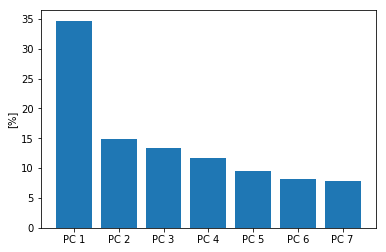

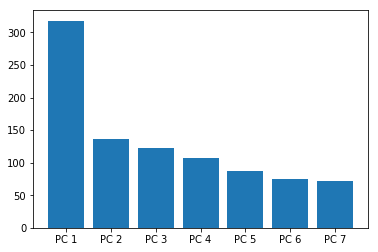

In [20]:
display_scree_plot(kpca.lambdas_, number_of_components=7, percentage=True)
display_scree_plot(kpca.lambdas_, number_of_components=7, percentage=False)

In [22]:
def plot_nearest(origin, data, images, n, shape, cmap=None):
    
    nbrs = NearestNeighbors(n_neighbors=n, algorithm='brute').fit(data)
    distances, indices = nbrs.kneighbors(np.atleast_2d(origin))
    
    fig, axes = plt.subplots(shape[0], shape[1])
    fig.set_size_inches(6, 10)
    axes = axes.flatten()
    
    for i, img in enumerate(images[indices.flatten()]):
        axes[i].imshow(img, cmap=cmap)
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
        
    return fig

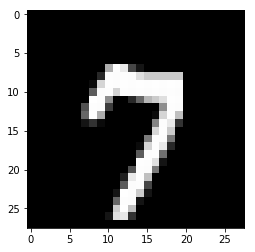

In [23]:
plt.imshow(images[121], cmap='gray')

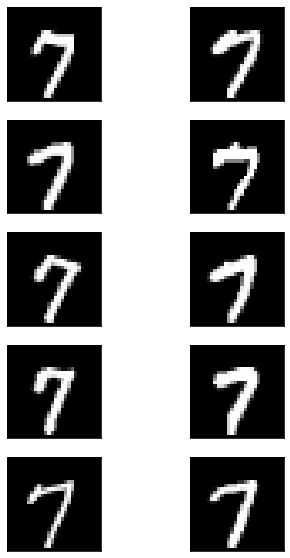

In [24]:
fig = plot_nearest(pca_components.iloc[121], pca_components, images, 10, (5, 2), cmap='gray')